In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import os
from PIL import Image

from shutil import copyfile
import base64
from io import BytesIO
from IPython.display import HTML
import pickle
import imutils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Activation
from keras.layers import Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model

from mtcnn.mtcnn import MTCNN
# print version

import cv2
import copy

from tqdm import tqdm
import glob

Using TensorFlow backend.


In [2]:
def print_conf_mat(conf_mat,labels,filename = ""):
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat,cmap = plt.cm.summer)
    for i, row in enumerate(conf_mat):
            for j, c in enumerate(row):
                if c>0:
                    plt.text(j-.2, i+.1, c, fontsize=16)

    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename+'.eps')
    plt.show()

In [3]:
class Image():
    
    def __init__(self, image, landmarks, name):
        # self.image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.image = image
        self.original_image = copy.deepcopy(self.image)
        self.landmarks = landmarks
        self.name = name
        self.neutralised_image = np.array([])
        self.hash = hash(self)
    
    def setNeutralisedImage(self, image):
        self.neutralised_image = image
        
    def getNeutralisedImage(self):
        return self.neutralised_image
        
    def getName(self):
        return self.name
        
    def getImage(self):
        return self.image
    
    def clearImage(self):
        self.image= copy.deepcopy(self.original_image)
        return self.image
    
    def getLandmarks(self):
        return self.landmarks
    
    def getHash(self):
        return self.hash

In [4]:
def getLandmarksForImage(imagePath):
    cur_landmark = "\\".join(str(imagePath).rsplit('\\',3)[-3:])[:-4]
    landmark_path = ck_landmarks_path + '\\' + cur_landmark + '_landmarks.txt'
    landmarks = np.loadtxt(landmark_path)
    return landmarks


def view_landmarks(landmarks, color='r'):
    xs, ys = list(zip(*landmarks))
    plt.scatter(xs, ys, color=color)
    return 

In [5]:
base_path = "..\\Data"

In [6]:
ck_data_path = base_path + '\\CK+\\cohn-kanade-images'
ck_landmarks_path = base_path + '\\CK+\\Landmarks'
ck_image_files = glob.glob(ck_data_path+'/**/*.png', recursive=True)

#ck_image_files = ck_image_files[7000:]

In [7]:
len(ck_image_files)

10708

In [8]:
face_det = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt_tree.xml")

def detect_face(f, ld):
    ''' function to detect face, crop the image and resize it and resize the corresponding landmarks too '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
#     ld = np.array([np.array(i) for i in ld])
    crop_ld = ld
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        fw, fh = w, h
        if any(ld[:,0] > x+w):
            fw = int(max(ld[:,0]-x))
        if any(ld[:,1] > y+h):
            fh = int(max(ld[:,1]-y))
#         gray = gray[y:y+h, x:x+w] #Cut the frame to size
        gray = gray[y:y+fh+5, x:x+fw+5] #Cut the frame to size to max of landmark with padding of 5px
        ld_rescale_factor = (gray.shape[1]/crop_imsize, (gray.shape[0]/crop_imsize))
        crop_ld = np.array(list(zip(ld[:,0]-x, ld[:, 1]-y)))
    try:
        output = cv2.resize(gray, (crop_imsize, crop_imsize))
        crop_ld = crop_ld/ld_rescale_factor
        cv2.imwrite(crop_path+'/crop_'+f.split('/')[-1], output)
    except:
        output = gray

    return output, crop_ld

In [9]:
images = []
crop_imsize = 160

with tqdm(total=len(ck_image_files), desc="Processing entries") as pbar:
    for i, ck_image in enumerate(ck_image_files):
        

        landmarks = getLandmarksForImage(ck_image)
        image, landmarks = detect_face(ck_image, landmarks)
        image = cv2.resize(image,(crop_imsize, crop_imsize))
        images.append(Image(image, landmarks, ck_image))
        
        pbar.update(1)

Processing entries: 100%|████████████████████████████████████████████████████████| 10708/10708 [30:13<00:00,  5.91it/s]


In [10]:
numImages = len(images)

avgLandmarks = (images[0].getLandmarks() / numImages)

for image in images[1:]:
    avgLandmarks += (image.getLandmarks()) / numImages

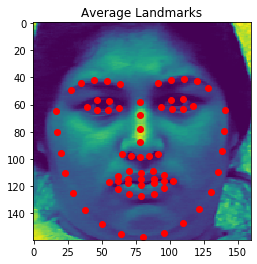

In [11]:
plt.imshow(images[0].getImage())
plt.title("Average Landmarks")
view_landmarks(avgLandmarks)

In [12]:
def appendLastRowAsCol(npMatrix):
    return np.c_[npMatrix[:-1,:].T, np.array([npMatrix[-1,:]]).T ]

In [13]:
def pairPlot(im1, im2, clear_figure=False, title=''):
    if not clear_figure:
        plt.figure()
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(im1)
    axes[1].imshow(im2)

    fig.suptitle(title, fontsize=16)
    
def getTrianglePts(triangle_points_array):
    return (tuple(triangle_points_array[0:2].astype(np.int32)), tuple(triangle_points_array[2:4].astype(np.int32)), tuple(triangle_points_array[4:6].astype(np.int32)))

def getTriangleImage(im, triangle_points_array):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    triangle = np.array([pt1, pt2, pt3])
    
    triangle_im = im
    triangle_mask = np.zeros_like(im)

    triangle_mask_fill_points = np.array([
            [pt1[0], pt1[1]],
            [pt2[0], pt2[1]],
            [pt3[0], pt3[1]]
        ], np.int32)
    cv2.fillConvexPoly(triangle_mask, triangle_mask_fill_points, (255,255,255))
    
    cropped_triangle = cv2.bitwise_and(triangle_mask, triangle_im)
        
    return cropped_triangle

def drawTriangle(im, triangle_points_array, color):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    
    cv2.line(im, pt1, pt2, color, 2)
    cv2.line(im, pt1, pt3, color, 2)
    cv2.line(im, pt3, pt2, color, 2)

def draw_delaunay(im, subdiv_triangles, color):

    for t in subdiv_triangles:
        drawTriangle(im, t, color)

def get_second_delaunay_triangles(im, src_triangles, src_landmarks, dest_landmarks):
    src_landmarks = np.array(src_landmarks).astype(np.float32)

    dest_triangles = np.array([[1,2,3,4,5,6]])
    for t in src_triangles:
        pt1 = np.array([t[0], t[1]])
        pt2 = np.array([t[2], t[3]])
        pt3 = np.array([t[4], t[5]])
  
        index_pt1 = np.where((pt1 == src_landmarks).all(axis=1))[0][0]
        index_pt2 = np.where((pt2 == src_landmarks).all(axis=1))[0][0]
        index_pt3 = np.where((pt3 == src_landmarks).all(axis=1))[0][0]

        dest_triangle = np.array([dest_landmarks[index_pt1], dest_landmarks[index_pt2], dest_landmarks[index_pt3]]).flatten()
        dest_triangles = np.concatenate((dest_triangles, np.array([dest_triangle])), axis=0)
    
    return dest_triangles[1:]

In [14]:
DRAW_EXAMPLE = False

dest = list(map(lambda x: tuple(x),avgLandmarks))

with tqdm(total=len(images), desc="Neutralizing emotions") as pbar:

    for image in images[:]:
        src = list(map(lambda x: tuple(x),image.getLandmarks()))

        image.clearImage()
        im = image.getImage()
        im_shape = im.shape

        rect = (0,0,im_shape[1],im_shape[0])
        subdiv = cv2.Subdiv2D(rect)
        
        try:
            subdiv.insert(src)
        except:
            pbar.update(1)
            continue
            
        src_triangles = subdiv.getTriangleList()

        dest_triangles = get_second_delaunay_triangles(im, src_triangles, src, dest)

        warped_image = np.zeros_like(im)      
        for (src_triangle, dest_triangle) in zip(src_triangles, dest_triangles):
            ## Change this code
            src_triangle = src_triangle.reshape(3,2).astype(np.float32)
            dest_triangle = dest_triangle.reshape(3,2).astype(np.float32)

            M = cv2.getAffineTransform(src_triangle, dest_triangle)

            src_triangle_image = getTriangleImage(im, src_triangle.flatten())

            dest_boundingRect = cv2.boundingRect(dest_triangle)
            (dx, dy, dw, dh) = dest_boundingRect

            warped_image_triangle = cv2.warpAffine(src_triangle_image, M,  src_triangle_image.shape)

            warped_triangle_area = warped_image[dy: dy + dh, dx : dx + dw]        
            warped_triangle_area = cv2.add(warped_triangle_area, warped_image_triangle[dy: dy + dh, dx : dx + dw])

            warped_image[dy: dy + dh, dx : dx + dw] = warped_triangle_area

        image.setNeutralisedImage(warped_image)
        pbar.update(1)

        if DRAW_EXAMPLE:
            print("DRAW_EXAMPLE IS TRUE")
            pairPlot(warped_image,im )
            break

Neutralizing emotions: 100%|█████████████████████████████████████████████████████| 10708/10708 [03:50<00:00, 46.38it/s]


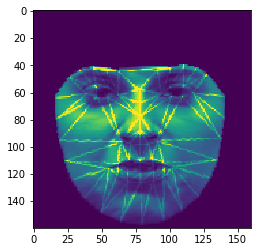

In [15]:
plt.imshow(images[257].getNeutralisedImage())

In [16]:
images[0].getName()

'..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000001.png'

In [17]:
import os
from PIL import Image

with tqdm(total=len(images), desc="Saving Neutralized emotions") as pbar:

    for image in images:

        path = "All_Images_Neutralised" + image.getName().split("Data")[-1]
        directory = "\\".join(path.split("\\")[:-1])

        if not os.path.exists(directory):
            os.makedirs(directory)

        try:
            im = Image.fromarray(image.getNeutralisedImage())
            im.save(path)
            pbar.update(1)
        except:
            
            pbar.update(1)
            continue

Saving Neutralized emotions: 100%|██████████████████████████████████████████████| 10708/10708 [00:16<00:00, 649.56it/s]


In [18]:
neutralized_image_files = glob.glob('NeutralisedImages\\CK+\\cohn-kanade-images/**/*.png', recursive=True)
len(neutralized_image_files)

3708

In [19]:
neutralized_image_files[1].split('\\')[3]

'S111'

In [20]:
def preprocess_neutralized(f,required_size=(160, 160)):
    ''' function to detect face, crop the image and resize it '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    
    image = Image.fromarray(gray)
    image = image.resize(required_size)
    image = image.convert('RGB')
    face_array = np.asarray(image)
    return face_array

In [21]:
faces_ck = list()
labels_ck  = list()
tmp_lab_prev = ''
tmp_lab = ''
for i in tqdm(range(len(neutralized_image_files)),desc = "Pre-processing neutralized images for FaceNet"):
    i_im = neutralized_image_files[i]
    tmp_lab = i_im.split('\\')[3]
    '''if(tmp_lab != tmp_lab_prev):
        print('Started pre-processing with subject:'+ tmp_lab)
    '''
    face = preprocess_neutralized(i_im)
    
     
    labels_ck.append(tmp_lab)
    
    # store
    faces_ck.append(face)
    tmp_lab_prev = tmp_lab

Pre-processing neutralized images for FaceNet: 100%|█████████████████████████████| 3708/3708 [00:02<00:00, 1551.70it/s]


In [22]:
ck_image_files[1].split('\\')[4]

'S005'

In [23]:
def preprocess_original(f,required_size=(160, 160)):
    ''' function to detect face, crop the image and resize it '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)

    
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        gray = gray[y:y+h, x:x+w] #Cut the frame to size
        
    
        image = Image.fromarray(gray)
        image = image.resize(required_size)
        image = image.convert('RGB')
        face_array = np.asarray(image)
    return face_array

In [24]:
tmp_lab_prev = ''
tmp_lab = ''
for i in tqdm(range(len(ck_image_files)),desc = "Pre-processing original images for FaceNet"):
    i_im = ck_image_files[i]
    tmp_lab = i_im.split('\\')[4]
    '''
    if(tmp_lab != tmp_lab_prev):
        print('Started pre-processing with subject:'+ tmp_lab)
    '''
    face = preprocess_original(i_im)
    
     
    labels_ck.append(tmp_lab)
    
    # store
    faces_ck.append(face)
    tmp_lab_prev = tmp_lab

Pre-processing original images for FaceNet: 100%|████████████████████████████████| 10708/10708 [30:08<00:00,  5.92it/s]


In [25]:
X_full_ck = np.asarray(faces_ck)
l_full_ck = np.asarray(labels_ck)

In [26]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X_full_ck, l_full_ck, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11532, 160, 160, 3), (2884, 160, 160, 3), (11532,), (2884,))

In [27]:
# save arrays to one file in compressed format
np.savez_compressed('ck+dataset-combined.npz', X_train, y_train, X_test, y_test)

In [28]:
# load the face dataset
data = np.load('ck+dataset-combined.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (11532, 160, 160, 3) (11532,) (2884, 160, 160, 3) (2884,)


# Load pre-trained FaceNET model

In [29]:


model = load_model('..\\Data\\Model\\model\\facenet_keras.h5')

print(model.inputs)
print(model.outputs)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\anan2\Anaconda3\envs\test\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Merge:0' shape=(?, 128) dtype=float32>]



# Use FaceNet to generate embeddings for each image

In [30]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [31]:
# convert each face in the train set to an embedding
newTrainX = list()
for i in tqdm(range(trainX.shape[0]),desc = "Converting images in training set to embeddings using FaceNet"):
    face_pixels = trainX[i]
    embedding = get_embedding(model, face_pixels)
    '''if((i+1)% 100 == 0):
        print("Processed " + str(i+1) + " faces")
        '''
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

Converting images in training set to embeddings using FaceNet: 100%|█████████████| 11532/11532 [14:06<00:00, 13.62it/s]


(11532, 128)


In [32]:
# convert each face in the test set to an embedding
newTestX = list()
for i in tqdm(range(testX.shape[0]),desc = "Converting images in test set to embeddings using FaceNet"):
    face_pixels = testX[i]
    embedding = get_embedding(model, face_pixels)
    '''if((i+1)% 100 == 0):
        print("Processed " + str(i+1) + " faces")
    '''
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

Converting images in test set to embeddings using FaceNet: 100%|███████████████████| 2884/2884 [03:21<00:00, 14.30it/s]


(2884, 128)


In [33]:
# save arrays to one file in compressed format
np.savez_compressed('ck+-faces-embeddings-combined.npz', newTrainX, trainy, newTestX, testy)


# Train an SVM to do the recognition

In [34]:
# load necessary libraries
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot


In [35]:
# load faces
data = load('ck+dataset-combined.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('ck+-faces-embeddings-combined.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model_SVM = SVC(kernel='linear', probability=True)
model_SVM.fit(trainX, trainy)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## Performance evaluation


In [36]:
# prediction vector for the test set
yhat_accuracy = model_SVM.score(testX, testy)
print("Accuracy on test set = "+str(yhat_accuracy*100) + "%")

Accuracy on test set = 100.0%


In [37]:
y_pred_shape_free = model_SVM.predict(testX)
c_mat_val = confusion_matrix(testy, y_pred_shape_free)
c_mat_val

array([[ 2,  0,  0, ...,  0,  0,  0],
       [ 0, 16,  0, ...,  0,  0,  0],
       [ 0,  0, 26, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 52,  0,  0],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  0, 35]], dtype=int64)

## Results on some random samples from test set

2620
Predicted: S116 (78.255)
Expected: S116


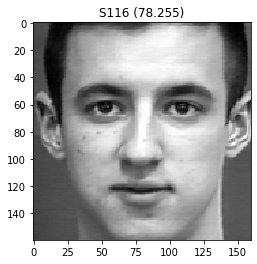

950
Predicted: S071 (65.217)
Expected: S071


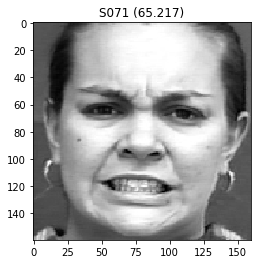

2185
Predicted: S151 (52.252)
Expected: S151


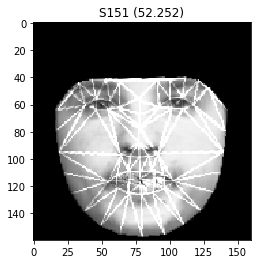

2465
Predicted: S127 (81.572)
Expected: S127


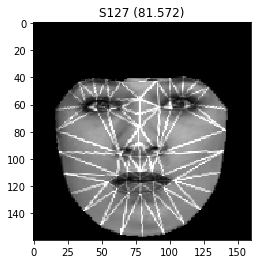

784
Predicted: S135 (78.648)
Expected: S135


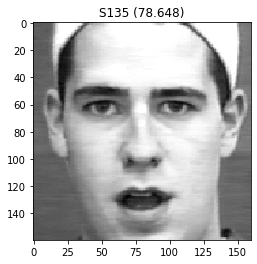

278
Predicted: S092 (43.554)
Expected: S092


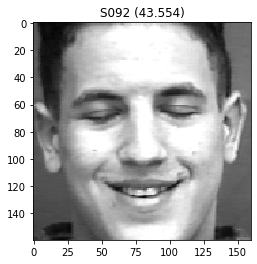

1229
Predicted: S136 (74.485)
Expected: S136


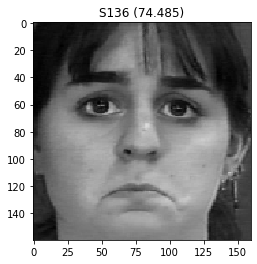

1260
Predicted: S037 (80.671)
Expected: S037


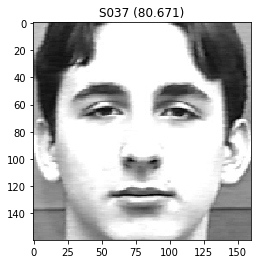

312
Predicted: S077 (73.187)
Expected: S077


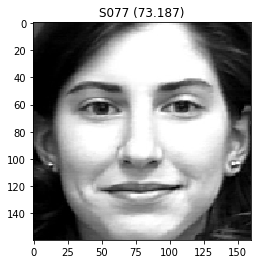

512
Predicted: S073 (70.593)
Expected: S073


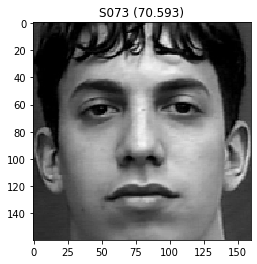

27
Predicted: S130 (87.842)
Expected: S130


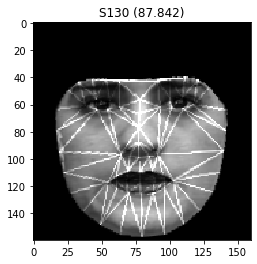

1295
Predicted: S077 (79.485)
Expected: S077


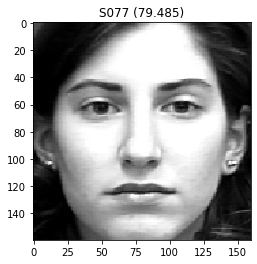

2145
Predicted: S094 (30.956)
Expected: S094


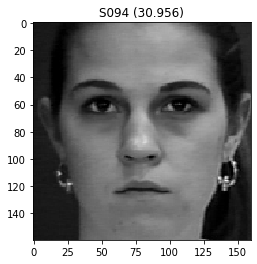

743
Predicted: S103 (64.167)
Expected: S103


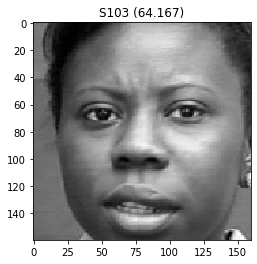

147
Predicted: S100 (57.562)
Expected: S100


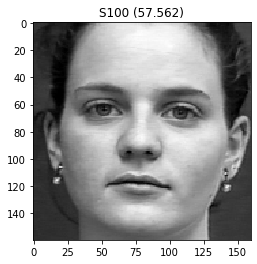

2010
Predicted: S132 (87.725)
Expected: S132


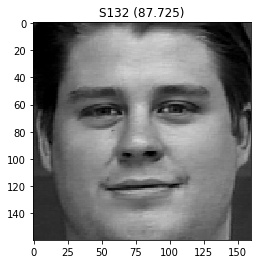

2286
Predicted: S115 (90.713)
Expected: S115


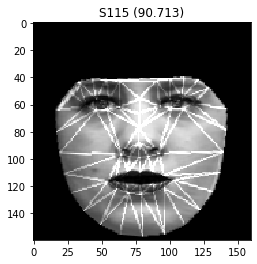

33
Predicted: S097 (75.855)
Expected: S097


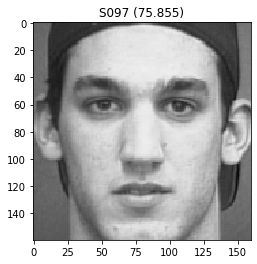

172
Predicted: S124 (89.164)
Expected: S124


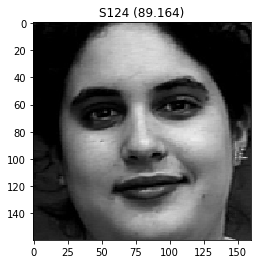

1078
Predicted: S090 (31.629)
Expected: S090


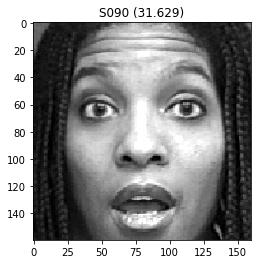

371
Predicted: S113 (93.093)
Expected: S113


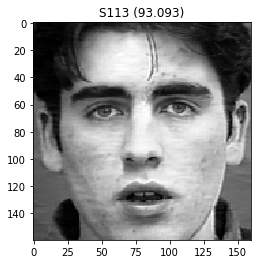

1740
Predicted: S035 (67.407)
Expected: S035


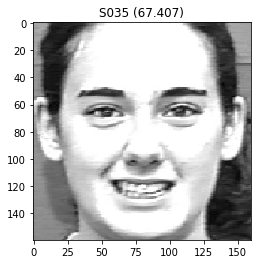

1459
Predicted: S078 (78.923)
Expected: S078


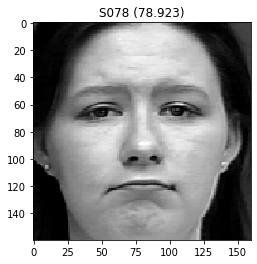

2298
Predicted: S052 (72.270)
Expected: S052


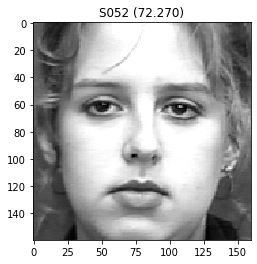

212
Predicted: S088 (58.670)
Expected: S088


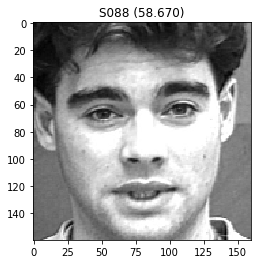

1464
Predicted: S051 (48.157)
Expected: S051


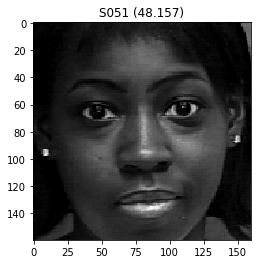

1136
Predicted: S078 (75.589)
Expected: S078


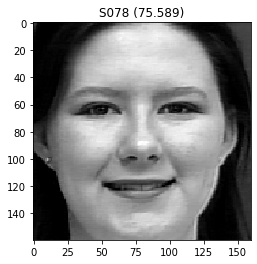

1391
Predicted: S135 (84.077)
Expected: S135


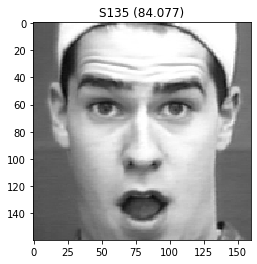

2423
Predicted: S109 (65.144)
Expected: S109


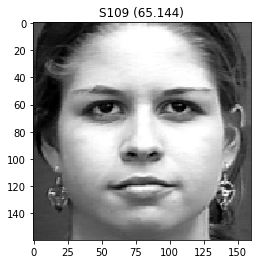

2463
Predicted: S105 (73.809)
Expected: S105


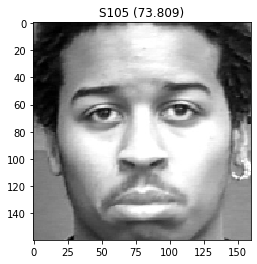

2231
Predicted: S502 (74.241)
Expected: S502


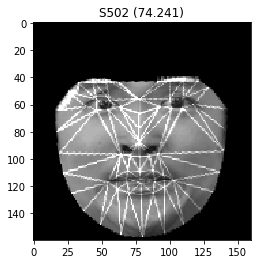

953
Predicted: S101 (55.747)
Expected: S101


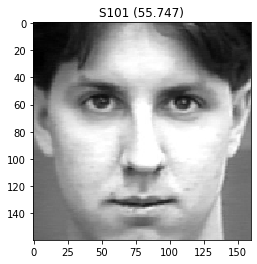

694
Predicted: S126 (86.752)
Expected: S126


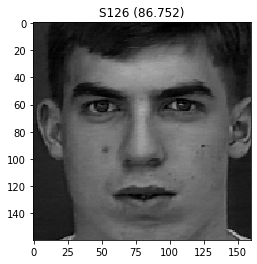

1705
Predicted: S051 (47.567)
Expected: S051


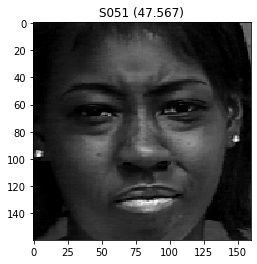

644
Predicted: S055 (78.075)
Expected: S055


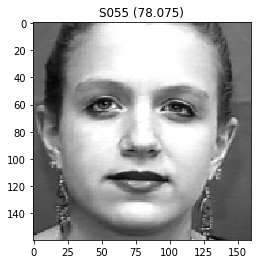

1153
Predicted: S055 (61.617)
Expected: S055


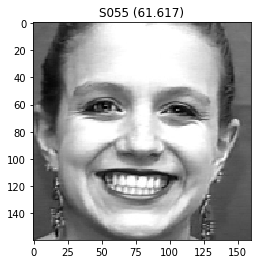

124
Predicted: S093 (44.981)
Expected: S093


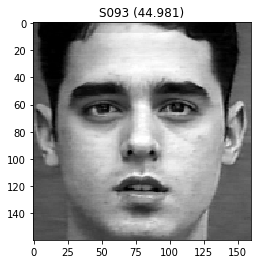

609
Predicted: S091 (40.724)
Expected: S091


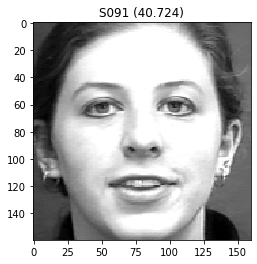

2707
Predicted: S124 (88.427)
Expected: S124


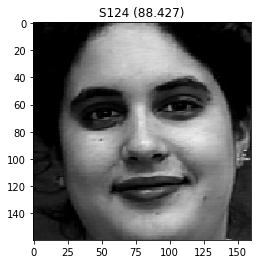

2548
Predicted: S501 (89.300)
Expected: S501


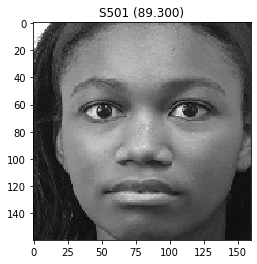

2585
Predicted: S126 (89.151)
Expected: S126


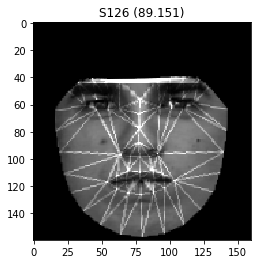

1611
Predicted: S137 (78.380)
Expected: S137


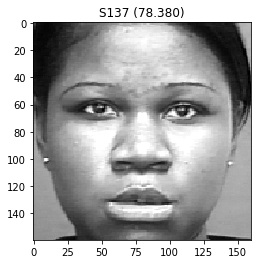

2514
Predicted: S054 (54.517)
Expected: S054


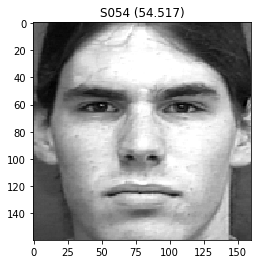

1859
Predicted: S116 (71.709)
Expected: S116


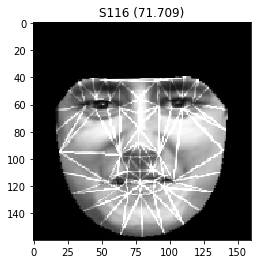

1577
Predicted: S093 (50.971)
Expected: S093


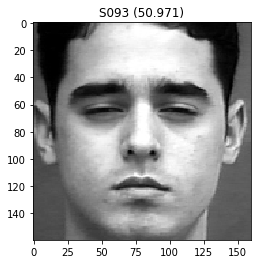

2009
Predicted: S501 (94.609)
Expected: S501


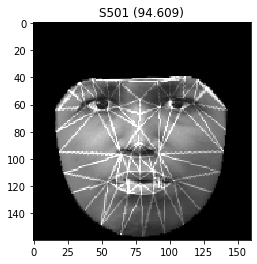

2218
Predicted: S119 (88.199)
Expected: S119


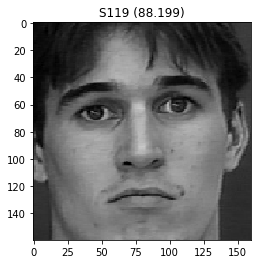

1423
Predicted: S124 (90.295)
Expected: S124


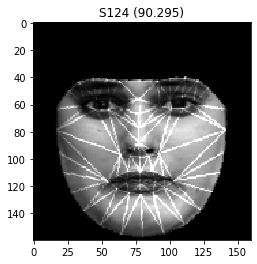

738
Predicted: S130 (94.844)
Expected: S130


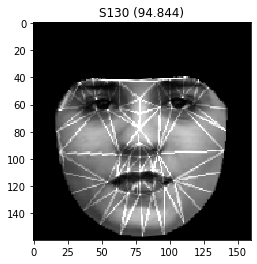

405
Predicted: S083 (42.525)
Expected: S083


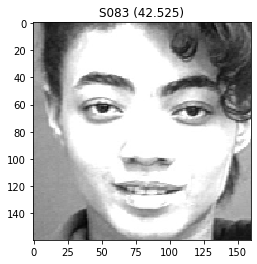

1799
Predicted: S051 (37.855)
Expected: S051


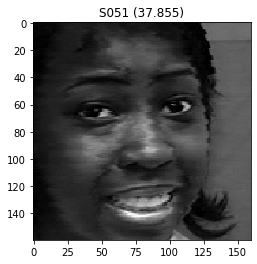

604
Predicted: S137 (75.862)
Expected: S137


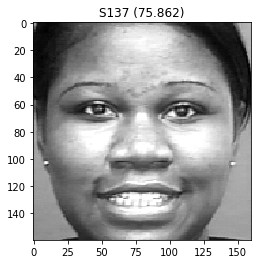

1006
Predicted: S128 (79.508)
Expected: S128


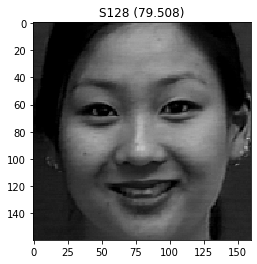

1439
Predicted: S051 (46.754)
Expected: S051


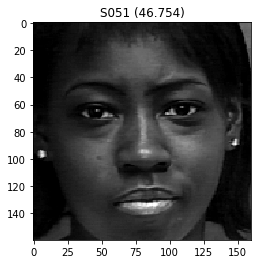

2276
Predicted: S095 (69.515)
Expected: S095


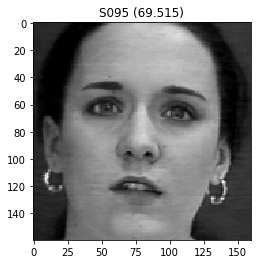

653
Predicted: S089 (44.485)
Expected: S089


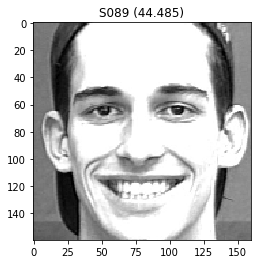

2879
Predicted: S057 (67.095)
Expected: S057


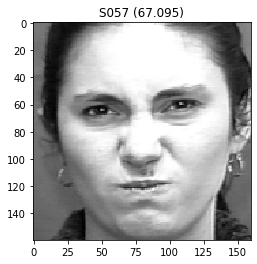

2681
Predicted: S081 (77.040)
Expected: S081


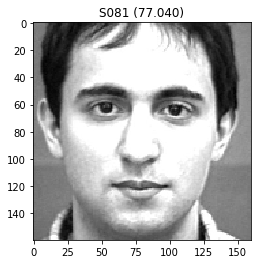

525
Predicted: S057 (77.866)
Expected: S057


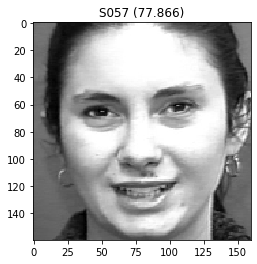

673
Predicted: S127 (87.561)
Expected: S127


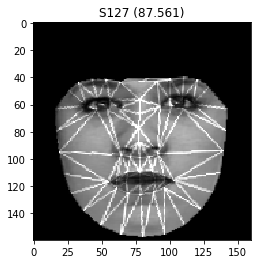

1113
Predicted: S106 (63.610)
Expected: S106


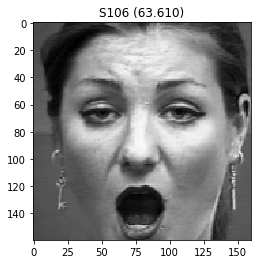

223
Predicted: S129 (84.189)
Expected: S129


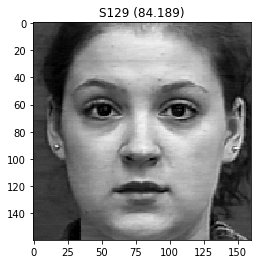

2767
Predicted: S117 (87.548)
Expected: S117


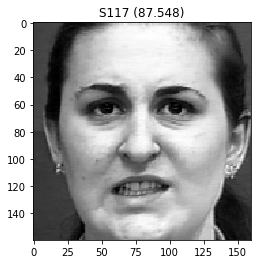

602
Predicted: S068 (66.812)
Expected: S068


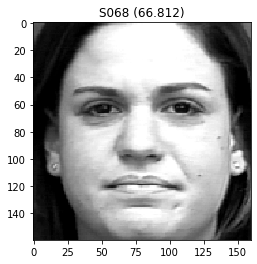

91
Predicted: S999 (81.725)
Expected: S999


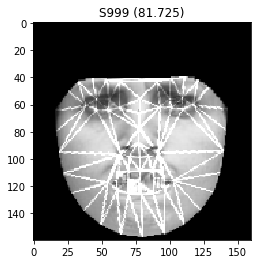

72
Predicted: S999 (80.184)
Expected: S999


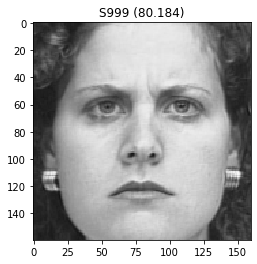

76
Predicted: S115 (84.262)
Expected: S115


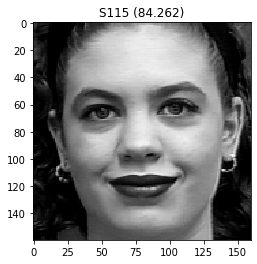

241
Predicted: S122 (70.403)
Expected: S122


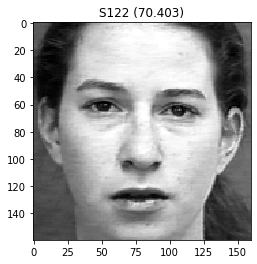

401
Predicted: S136 (72.723)
Expected: S136


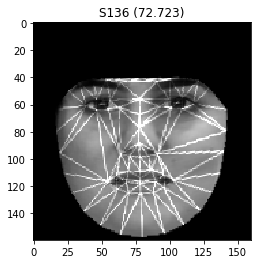

792
Predicted: S147 (26.081)
Expected: S147


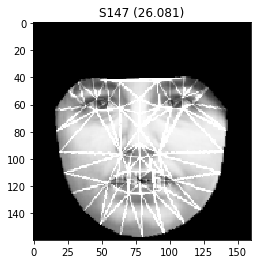

535
Predicted: S100 (63.141)
Expected: S100


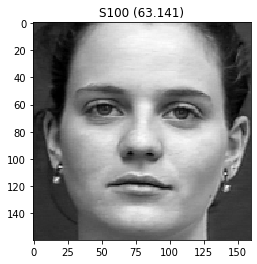

2475
Predicted: S501 (85.341)
Expected: S501


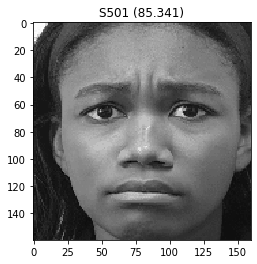

1150
Predicted: S133 (94.044)
Expected: S133


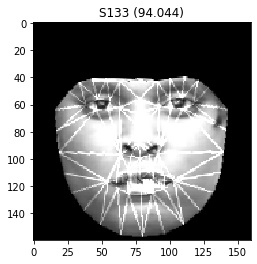

2667
Predicted: S073 (69.387)
Expected: S073


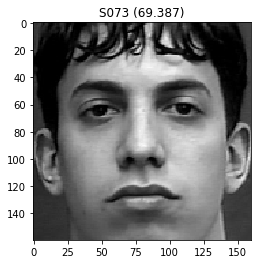

963
Predicted: S121 (86.812)
Expected: S121


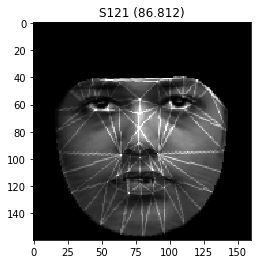

2496
Predicted: S131 (84.966)
Expected: S131


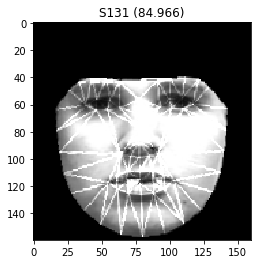

1192
Predicted: S125 (85.812)
Expected: S125


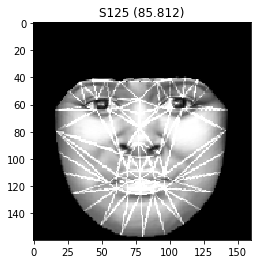

2662
Predicted: S060 (57.261)
Expected: S060


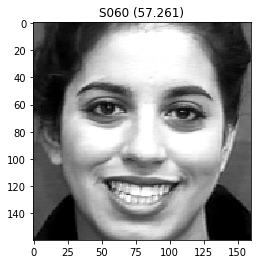

1677
Predicted: S126 (80.376)
Expected: S126


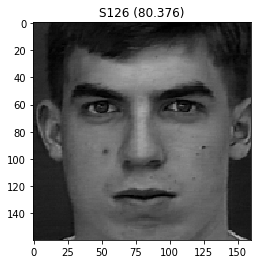

192
Predicted: S111 (85.961)
Expected: S111


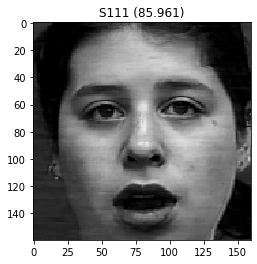

2077
Predicted: S131 (88.073)
Expected: S131


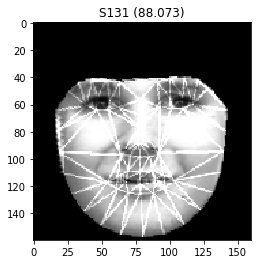

76
Predicted: S115 (84.262)
Expected: S115


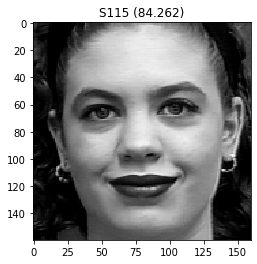

1243
Predicted: S119 (90.068)
Expected: S119


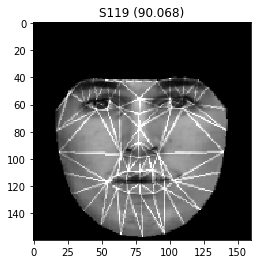

544
Predicted: S072 (58.328)
Expected: S072


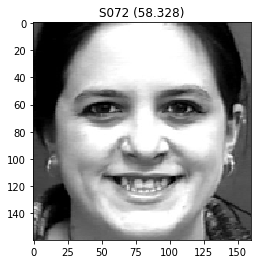

434
Predicted: S071 (69.714)
Expected: S071


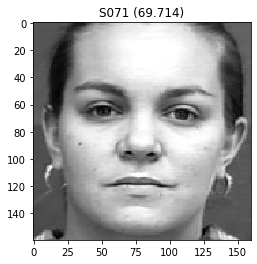

1353
Predicted: S112 (82.376)
Expected: S112


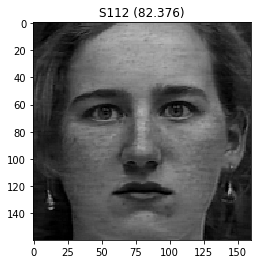

1456
Predicted: S158 (20.339)
Expected: S158


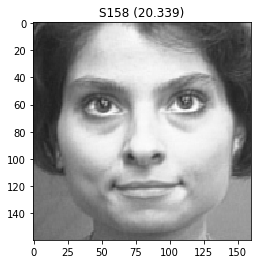

2681
Predicted: S081 (77.040)
Expected: S081


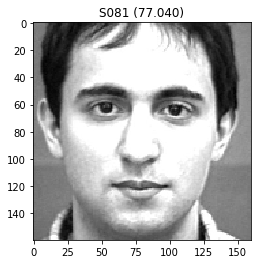

2444
Predicted: S130 (87.152)
Expected: S130


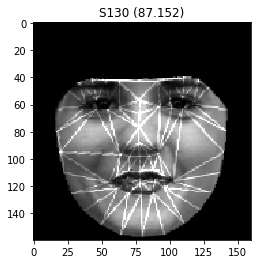

1293
Predicted: S133 (76.422)
Expected: S133


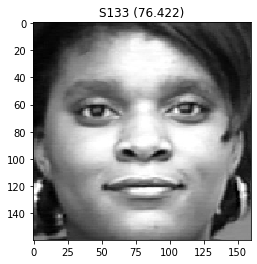

2332
Predicted: S093 (48.313)
Expected: S093


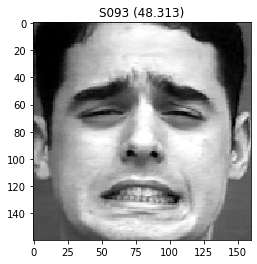

77
Predicted: S088 (52.320)
Expected: S088


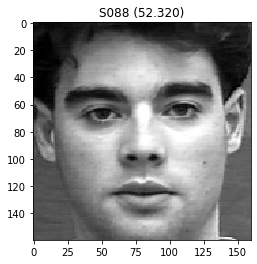

775
Predicted: S132 (81.197)
Expected: S132


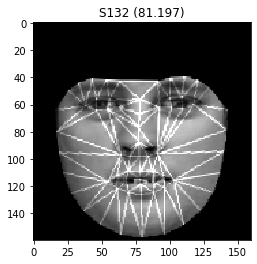

646
Predicted: S112 (84.325)
Expected: S112


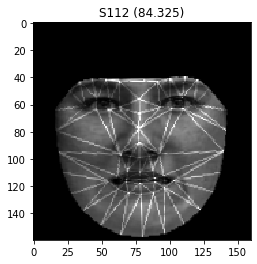

2653
Predicted: S124 (90.483)
Expected: S124


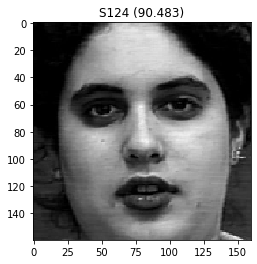

2505
Predicted: S078 (76.777)
Expected: S078


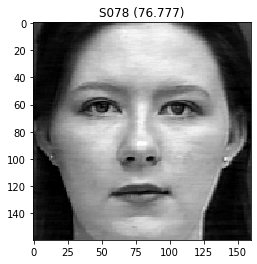

1775
Predicted: S078 (80.139)
Expected: S078


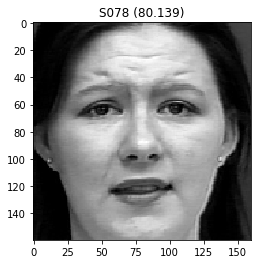

2623
Predicted: S117 (89.041)
Expected: S117


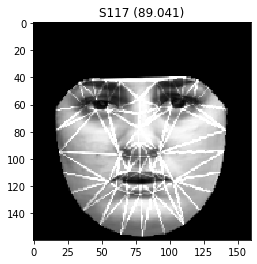

1382
Predicted: S120 (17.197)
Expected: S120


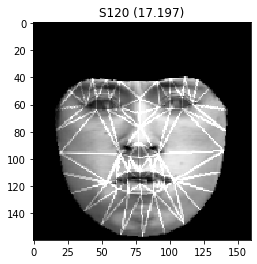

95
Predicted: S119 (83.539)
Expected: S119


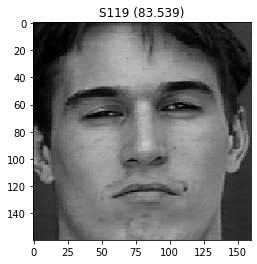

In [38]:
num_runs = 100
for ind in range(num_runs):
    # test model on a random example from the test dataset
    selection = choice([i for i in range(testX.shape[0])])
    print(selection)
    random_face_pixels = testX_faces[selection]
    random_face_emb = testX[selection]
    random_face_class = testy[selection]
    random_face_name = out_encoder.inverse_transform([random_face_class])
    # prediction for the face
    samples = expand_dims(random_face_emb, axis=0)
    yhat_class = model_SVM.predict(samples)
    yhat_prob = model_SVM.predict_proba(samples)
    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)
    print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
    print('Expected: %s' % random_face_name[0])
    # plot for fun
    pyplot.imshow(random_face_pixels)
    title = '%s (%.3f)' % (predict_names[0], class_probability)
    pyplot.title(title)
    pyplot.show()